# Hyperparameters tuning

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from datasets.methods import dataset_information, delete_dataset_features, fill_dataset_samples, extract_samples_labels
from predictors.treepredictors import TreePredictor
from commons.stopping_criteria import TreeMaximumDepth, TreeMaximumLeaves, TreeMaximumNodes, NodeMinimumSamples, NodeImpurityLevel
from commons.splitting_criteria import ThresholdCondition, MembershipCondition
from commons.splitting_criteria import information_gain, entropy
from commons.losses import zero_one_loss, samples_error, create_folds, cross_validation, flat_cross_validation
from commons.plotting import plot_train_test_error, plot_confusion_matrices

## Dataset & preprocessing

In [2]:
## CONSTANTS

DATASET_FILENAME = 'datasets/mushroom_secondary.csv'
SAMPLES_NUMBER = 10_000
DELETION_THRESHOLD = 0.20
IMPUTATION_VALUE = 'u'
NORMALIZATION = True
RANDOM_SEED = 1234

In [3]:
## Loading dataset

mushroom_dataset = pd.read_csv(DATASET_FILENAME, sep=';')
mushroom_dataset = mushroom_dataset.sample(SAMPLES_NUMBER, random_state=RANDOM_SEED)

## Dataset preprocessing

mushroom_dataset = delete_dataset_features(mushroom_dataset, DELETION_THRESHOLD)
mushroom_dataset = fill_dataset_samples(mushroom_dataset, IMPUTATION_VALUE)
samples_set, labels_set = extract_samples_labels(mushroom_dataset)

## Train and test split

In [4]:
## CONSTANTS

RANDOM_SEED = 1234
TEST_SIZE = 0.2
SHUFFLE = True

In [5]:
## Train and test split

train_sample_set, test_sample_set, train_labels_set, test_labels_set = train_test_split(samples_set, labels_set, test_size=TEST_SIZE, shuffle=SHUFFLE, random_state=RANDOM_SEED)

print(f'Original dataset size: {len(samples_set)}')
print(f'Train set size:        {len(train_sample_set)}')
print(f'Test set size:         {len(test_sample_set)}')

Original dataset size: 10000
Train set size:        8000
Test set size:         2000


In [6]:
## Hyperparameters (no limitations)

continuous_condition = ThresholdCondition
categorical_condition = MembershipCondition
node_stopping_criteria = []
tree_stopping_criteria = []
decision_metric = information_gain

In [7]:
## Model definition

tree_predictor = TreePredictor(
    continuous_condition=continuous_condition,
    categorical_condition=categorical_condition,
    decision_metric=decision_metric,
    tree_stopping_criteria=tree_stopping_criteria,
    node_stopping_criteria=node_stopping_criteria
)

In [8]:
## Model training

tree_predictor.fit(train_sample_set, train_labels_set)

print(f'Tree depth: {tree_predictor._depth}')
print(f'Tree total nodes: {tree_predictor._nodes_count}')
print(f'Tree leaf nodes: {tree_predictor._leaves_count}')

Tree depth: 24
Tree total nodes: 447
Tree leaf nodes: 224


In [9]:
## Model evaluation

predictor = tree_predictor.predict
train_error = samples_error(predictor, zero_one_loss, train_labels_set, train_sample_set)
test_error = samples_error(predictor, zero_one_loss, test_labels_set, test_sample_set)

print(f'Train error: {train_error}')
print(f'Test error:  {test_error}')

Train error: 0.0
Test error:  0.017


## Cross validation

In [10]:
## CONSTANTS

FOLDS = 5
RANDOM_SEED = 1234
VERBOSE = True

In [11]:
## Folds split

np.random.seed(RANDOM_SEED)
np.random.shuffle(samples_set)
np.random.seed(RANDOM_SEED)
np.random.shuffle(labels_set)

data_folds = create_folds(samples_set, FOLDS)
labels_folds = create_folds(labels_set, FOLDS)

print(f'Original dataset size: {len(samples_set)}')
print(f'Folds number:          {len(data_folds)}')
print(f'folds size:            {len(data_folds[0])}')

Original dataset size: 10000
Folds number:          5
folds size:            2000


In [12]:
## Hyperparameters (no limitations)

continuous_condition = ThresholdCondition
categorical_condition = MembershipCondition
node_stopping_criteria = []
tree_stopping_criteria = []
decision_metric = information_gain

In [13]:
## Model definition

tree_predictor = TreePredictor(
    continuous_condition=continuous_condition,
    categorical_condition=categorical_condition,
    decision_metric=decision_metric,
    tree_stopping_criteria=tree_stopping_criteria,
    node_stopping_criteria=node_stopping_criteria
)

In [14]:
## Cross validation

cross_validation_value = cross_validation(tree_predictor, zero_one_loss, data_folds, labels_folds, VERBOSE)

print(f'final cross validation estimation: {cross_validation_value}')

Running cross validation on 5 folds of size 2000
Fold 0 iteration:
Training model on folds [-0]...
Testing model on fold [0]...
> fold [0] error: 0.017
Fold 1 iteration:
Training model on folds [-1]...
Testing model on fold [1]...
> fold [1] error: 0.026
Fold 2 iteration:
Training model on folds [-2]...
Testing model on fold [2]...
> fold [2] error: 0.023
Fold 3 iteration:
Training model on folds [-3]...
Testing model on fold [3]...
> fold [3] error: 0.0135
Fold 4 iteration:
Training model on folds [-4]...
Testing model on fold [4]...
> fold [4] error: 0.017
>> final cross validation value: 0.0193
final cross validation estimation: 0.0193


## Flat Cross Validation

In [15]:
## CONSTANTS

FOLDS = 5
VERBOSE = True

TREE_MAXIMUM_DEPTH_START, TREE_MAXIMUM_DEPTH_END, TREE_MAXIMUM_DEPTH_STEP = 25, 26, 1
TREE_MAXIMUM_LEAVES_START, TREE_MAXIMUM_LEAVES_END, TREE_MAXIMUM_LEAVES_STEP = 150, 250, 100
TREE_MAXIMUM_NODES_START, TREE_MAXIMUM_NODES_END, TREE_MAXIMUM_NODES_STEP = 400, 501, 100
NODE_MINIMUM_SAMPLES_START, NODE_MINIMUM_SAMPLES_END, NODE_MINIMUM_SAMPLES_STEP = 50, 156, 50
IMPURITY_LEVEL_START, IMPURITY_LEVEL_END, IMPURITY_LEVEL_STEP = 0.0, 0.26, 0.25

In [16]:
## Hyperparameters Grid

continuous_condition_range = [ThresholdCondition]
categorical_condition_range = [MembershipCondition]
decision_metric_range = [information_gain]
maximum_depths = [TreeMaximumDepth(depth) for depth in np.arange(TREE_MAXIMUM_DEPTH_START, TREE_MAXIMUM_DEPTH_END, TREE_MAXIMUM_DEPTH_STEP)]
maximum_leaves = [TreeMaximumLeaves(number) for number in np.arange(TREE_MAXIMUM_LEAVES_START, TREE_MAXIMUM_LEAVES_END, TREE_MAXIMUM_LEAVES_STEP)]
maximum_nodes = [TreeMaximumNodes(number) for number in np.arange(TREE_MAXIMUM_NODES_START, TREE_MAXIMUM_NODES_END, TREE_MAXIMUM_NODES_STEP)]
tree_stopping_criteria_range = np.array(np.meshgrid(maximum_depths, maximum_leaves, maximum_nodes)).T.reshape(-1, 3)
minimum_samples = [NodeMinimumSamples(number) for number in np.arange(NODE_MINIMUM_SAMPLES_START, NODE_MINIMUM_SAMPLES_END, NODE_MINIMUM_SAMPLES_STEP)]
impurity_levels = [NodeImpurityLevel(entropy, threshold) for threshold in np.arange(IMPURITY_LEVEL_START, IMPURITY_LEVEL_END, IMPURITY_LEVEL_STEP)]
node_stopping_criteria_range = np.array(np.meshgrid(minimum_samples, impurity_levels)).T.reshape(-1, 2)

hyperparameters_grid = list(itertools.product(
    continuous_condition_range,
    categorical_condition_range,
    decision_metric_range,
    tree_stopping_criteria_range,
    node_stopping_criteria_range
))

print(f'Grid dimensions: {len(hyperparameters_grid)}')
print(f'Hyperparameters example: {hyperparameters_grid[0]}')

Grid dimensions: 12
Hyperparameters example: (<class 'commons.splitting_criteria.ThresholdCondition'>, <class 'commons.splitting_criteria.MembershipCondition'>, <function information_gain at 0x0000012A27648C20>, array([<commons.stopping_criteria.TreeMaximumDepth object at 0x0000012A27820B10>,
      dtype=object), array([<commons.stopping_criteria.NodeMinimumSamples object at 0x0000012A27569F50>,
      dtype=object))


In [17]:
## Flat Cross Validation

ncv_value, best_hyperparameters = flat_cross_validation(TreePredictor, zero_one_loss, samples_set, labels_set, FOLDS, hyperparameters_grid, VERBOSE)

Running flat cross validation on 5 folds of size 2000
- cross validation using parameters (<class 'commons.splitting_criteria.ThresholdCondition'>, <class 'commons.splitting_criteria.MembershipCondition'>, <function information_gain at 0x0000012A27648C20>, array([<commons.stopping_criteria.TreeMaximumDepth object at 0x0000012A27820B10>,
      dtype=object), array([<commons.stopping_criteria.NodeMinimumSamples object at 0x0000012A27569F50>,
      dtype=object))
Fold [-0] iteration:
Training fold [-0] best model...
Testing fold [0] best model...
result: 0.055
Fold [-1] iteration:
Training fold [-1] best model...
Testing fold [1] best model...
result: 0.0555
Fold [-2] iteration:
Training fold [-2] best model...
Testing fold [2] best model...
result: 0.05
Fold [-3] iteration:
Training fold [-3] best model...
Testing fold [3] best model...
result: 0.047
Fold [-4] iteration:
Training fold [-4] best model...
Testing fold [4] best model...
result: 0.0455
> Hyperparameter total loss: 0.253
- cr

In [18]:
print(f'final nested cross validation value: {ncv_value}')
print(f'Best hyperparameters:')
print(f'continuous condition: {best_hyperparameters[0].__name__}')
print(f'categorical condition: {best_hyperparameters[1].__name__}')
print(f'decision metric: {best_hyperparameters[2].__name__}')
print(f'tree stopping criteria: {[str(condition) for condition in best_hyperparameters[3]]}')
print(f'node stopping criteria: {[str(condition) for condition in best_hyperparameters[4]]}')

final nested cross validation value: 0.0506
Best hyperparameters:
continuous condition: ThresholdCondition
categorical condition: MembershipCondition
decision metric: information_gain
tree stopping criteria: ['tree depth > 25', 'tree leaves count > 150', 'tree nodes count > 400']
node stopping criteria: ['samples number <= 50', 'entropy impurity <= 0.0']


In [19]:
## Best model training

continuous_condition = best_hyperparameters[0]
categorical_condition = best_hyperparameters[1]
decision_metric = best_hyperparameters[2]
tree_stopping_criteria = best_hyperparameters[3]
node_stopping_criteria = best_hyperparameters[4]

best_model = TreePredictor(continuous_condition, categorical_condition, decision_metric, tree_stopping_criteria, node_stopping_criteria)

train_sample_set, test_sample_set, train_labels_set, test_labels_set = train_test_split(samples_set, labels_set, test_size=TEST_SIZE, shuffle=SHUFFLE, random_state=RANDOM_SEED)

best_model.fit(train_sample_set, train_labels_set)

In [20]:
## Best model evaluation

predictor = best_model.predict
train_error = samples_error(predictor, zero_one_loss, train_labels_set, train_sample_set)
test_error = samples_error(predictor, zero_one_loss, test_labels_set, test_sample_set)

print(f'Train error: {train_error}')
print(f'Test error:  {test_error}')

Train error: 0.04625
Test error:  0.054


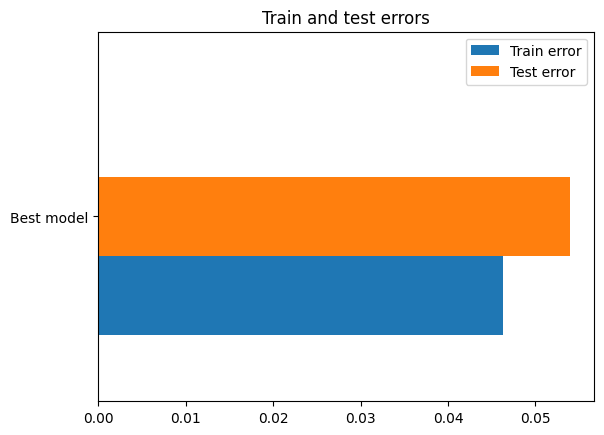

In [21]:
plot_train_test_error(['Best model'], [train_error], [test_error])

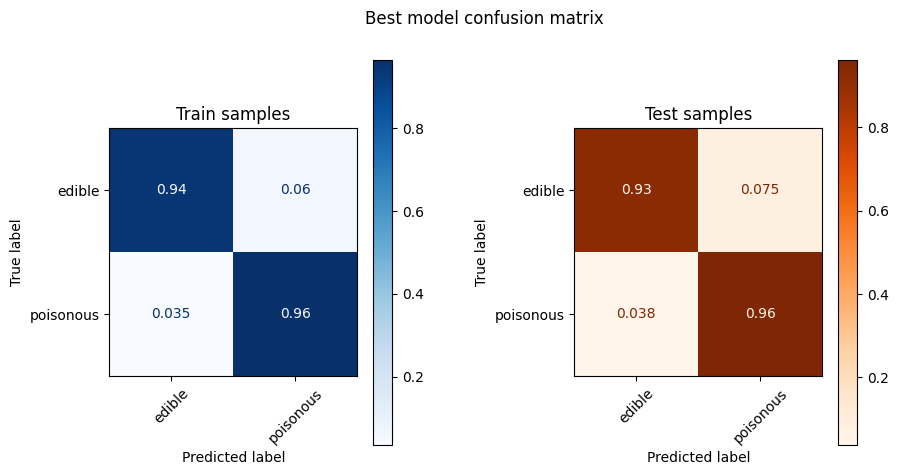

In [22]:
train_predictions = best_model.predict(train_sample_set)
test_predictions = best_model.predict(test_sample_set)
labels = ['edible', 'poisonous']

train_confusion_matrix = confusion_matrix(train_labels_set, train_predictions, normalize='true')
test_confusion_matrix = confusion_matrix(test_labels_set, test_predictions, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Best model confusion matrix')
plt.subplots_adjust(wspace=0.5)

matrix_display = ConfusionMatrixDisplay(train_confusion_matrix, display_labels=labels)
matrix_display.plot(ax=axes[0], xticks_rotation=45, cmap='Blues')
matrix_display.ax_.set_title('Train samples')

matrix_display = ConfusionMatrixDisplay(test_confusion_matrix, display_labels=labels)
matrix_display.plot(ax=axes[1], xticks_rotation=45, cmap='Oranges')
matrix_display.ax_.set_title('Test samples')

plt.show()
